In [1]:
import json
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import tensorflow.keras as K
import tensorflow as tf
from tensorflow.keras.layers import Input, Dropout, Conv2D, Flatten, Dense, Activation, Add, BatchNormalization, MaxPooling2D 
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam

In [2]:
def load_data(data_path):
    with open(data_path, "r") as fp:
        data = json.load(fp)

    X = np.array(data["mfcc"])
    y = np.array(data["labels"])
    mapping = data["mapping"]
    return X, y, mapping

In [3]:
json_path = "../input/data-json/data_10.json"
X, y, mapping = load_data(json_path)

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

In [5]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1)

In [6]:
print(X_train.shape, X_test.shape, X_val.shape)
print(y_train.shape, y_test.shape, y_val.shape)

(6740, 130, 13) (2497, 130, 13) (749, 130, 13)
(6740,) (2497,) (749,)


In [7]:
X_train = np.expand_dims(X_train, -1)
X_test = X_test[..., np.newaxis]
X_val = np.expand_dims(X_val, -1)

In [8]:
def build_model(input_shape):
    model = K.Sequential()
    model.add(K.layers.Conv2D(64, (3, 3), input_shape=input_shape, activation="relu", padding="same"))
    model.add(K.layers.MaxPooling2D((2, 2), strides=(2, 2)))
    model.add(K.layers.BatchNormalization())
    
    model.add(K.layers.Conv2D(128, (3, 3), activation="relu", padding="same"))
    model.add(K.layers.MaxPooling2D((2, 2), strides=(2, 2)))
    model.add(K.layers.BatchNormalization())

    model.add(K.layers.Conv2D(256, (3, 3), activation="relu", padding="same"))
    model.add(K.layers.MaxPooling2D((2, 2), strides=(2, 2)))
    model.add(K.layers.BatchNormalization())
    
    model.add(K.layers.Flatten())
    model.add(K.layers.Dense(64, activation="relu"))
    model.add(K.layers.Dense(10, activation="softmax"))
    return model

In [9]:
model = build_model(X_train[0].shape)
optimizer = K.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 130, 13, 64)       640       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 65, 6, 64)         0         
_________________________________________________________________
batch_normalization (BatchNo (None, 65, 6, 64)         256       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 65, 6, 128)        73856     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 3, 128)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 3, 128)        512       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 3, 256)        2

2021-11-01 07:12:23.758464: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-01 07:12:23.866499: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-01 07:12:23.867555: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-01 07:12:23.869578: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

In [10]:
def lrdecay(epoch):
    lr = 1e-3
    if epoch > 10:
        lr *= 0.5e-3
    elif epoch > 20:
        lr *= 1e-3
    elif epoch > 30:
        lr *= 1e-2
    elif epoch > 35:
        lr *= 1e-1
    return lr
lrdecay = tf.keras.callbacks.LearningRateScheduler(lrdecay) 

In [11]:
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), batch_size=64, epochs=40)

2021-11-01 07:12:58.392350: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/40


2021-11-01 07:12:59.994512: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


106/106 [==============================] - 9s 12ms/step - loss: 1.5649 - accuracy: 0.4871 - val_loss: 4.4815 - val_accuracy: 0.2497
Epoch 2/40
106/106 [==============================] - 1s 8ms/step - loss: 1.0285 - accuracy: 0.6442 - val_loss: 1.0705 - val_accuracy: 0.6235
Epoch 3/40
106/106 [==============================] - 1s 8ms/step - loss: 0.6756 - accuracy: 0.7662 - val_loss: 1.2057 - val_accuracy: 0.6182
Epoch 4/40
106/106 [==============================] - 1s 8ms/step - loss: 0.4808 - accuracy: 0.8371 - val_loss: 1.1728 - val_accuracy: 0.6529
Epoch 5/40
106/106 [==============================] - 1s 8ms/step - loss: 0.3441 - accuracy: 0.8819 - val_loss: 1.0070 - val_accuracy: 0.6796
Epoch 6/40
106/106 [==============================] - 1s 8ms/step - loss: 0.2229 - accuracy: 0.9286 - val_loss: 0.7947 - val_accuracy: 0.7543
Epoch 7/40
106/106 [==============================] - 1s 8ms/step - loss: 0.1606 - accuracy: 0.9494 - val_loss: 0.8911 - val_accuracy: 0.7503
Epoch 8/40
106/1

In [12]:
def plot_history(history): 
    fig, axs = plt.subplots(2, figsize=(10, 10))

    # create accuracy sublpot
    axs[0].plot(history.history["accuracy"], label="train accuracy")
    axs[0].plot(history.history["val_accuracy"], label="valid accuracy")
    axs[0].set_ylabel("Accuracy")
    axs[0].set_xlabel("Epoch")
    axs[0].legend(loc="lower right")
    axs[0].set_title("Accuracy evaluation")

    # create error sublpot
    axs[1].plot(history.history["loss"], label="train loss")
    axs[1].plot(history.history["val_loss"], label="valid loss")
    axs[1].set_ylabel("Loss")
    axs[1].set_xlabel("Epoch")
    axs[1].legend(loc="upper right")
    axs[1].set_title("Valid evaluation")

    plt.show()

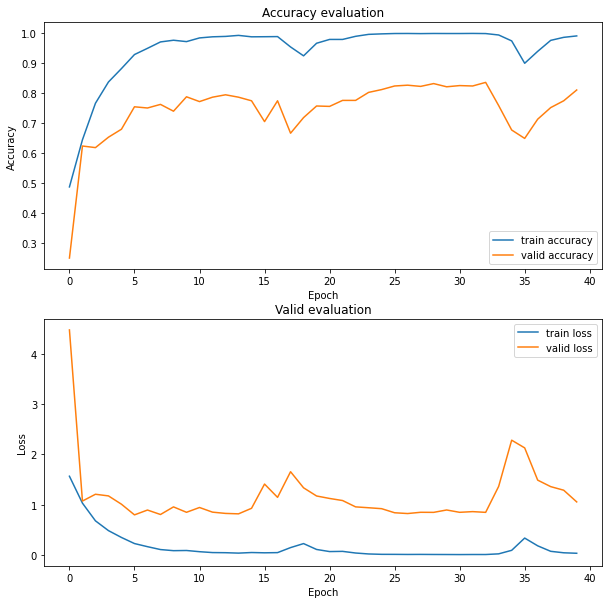

In [13]:
plot_history(history)

Overfitting

In [14]:
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=1)
print("Test loss : {}, Test accuracy: {}".format(test_loss, test_acc))

79/79 [==============================] - 1s 5ms/step - loss: 1.2261 - accuracy: 0.7797
Test loss : 1.2260680198669434, Test accuracy: 0.7797356843948364


In [15]:
from sklearn.metrics import classification_report, confusion_matrix
# Confusion matrix
y_predicted = model.predict(X_test)
y_predicted = np.argmax(y_predicted, axis=1)
confusion_matrix(y_test, y_predicted)

array([[178,   0,  14,   4,   7,  10,  12,   0,   1,   7],
       [  0, 218,   3,   0,   0,  22,   0,   0,   0,   4],
       [  9,   1, 180,  13,   3,  22,   6,   2,   2,  30],
       [  4,   3,   7, 199,   9,   7,   5,   2,   6,  10],
       [  4,   1,   2,  15, 199,   0,   5,   4,  12,   5],
       [  1,   3,   5,   0,   0, 237,   0,   0,   1,   1],
       [  3,   0,   0,   1,   4,   1, 228,   0,   0,  18],
       [  0,   0,  13,  19,  22,   6,   0, 170,   9,  10],
       [  1,   0,  12,  19,  16,   1,   0,   2, 179,   3],
       [ 15,   0,  23,  20,   8,  12,  16,   5,   7, 159]])

In [16]:
print(classification_report(y_test, y_predicted, target_names = mapping))

              precision    recall  f1-score   support

       blues       0.83      0.76      0.79       233
   classical       0.96      0.88      0.92       247
     country       0.69      0.67      0.68       268
       disco       0.69      0.79      0.73       252
      hiphop       0.74      0.81      0.77       247
        jazz       0.75      0.96      0.84       248
       metal       0.84      0.89      0.87       255
         pop       0.92      0.68      0.78       249
      reggae       0.82      0.77      0.80       233
        rock       0.64      0.60      0.62       265

    accuracy                           0.78      2497
   macro avg       0.79      0.78      0.78      2497
weighted avg       0.79      0.78      0.78      2497



In [17]:
mat = confusion_matrix(y_test, y_predicted)
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True, 
                          size_mat=(40, 30)):

    import itertools
    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')
    plt.figure(figsize=size_mat)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

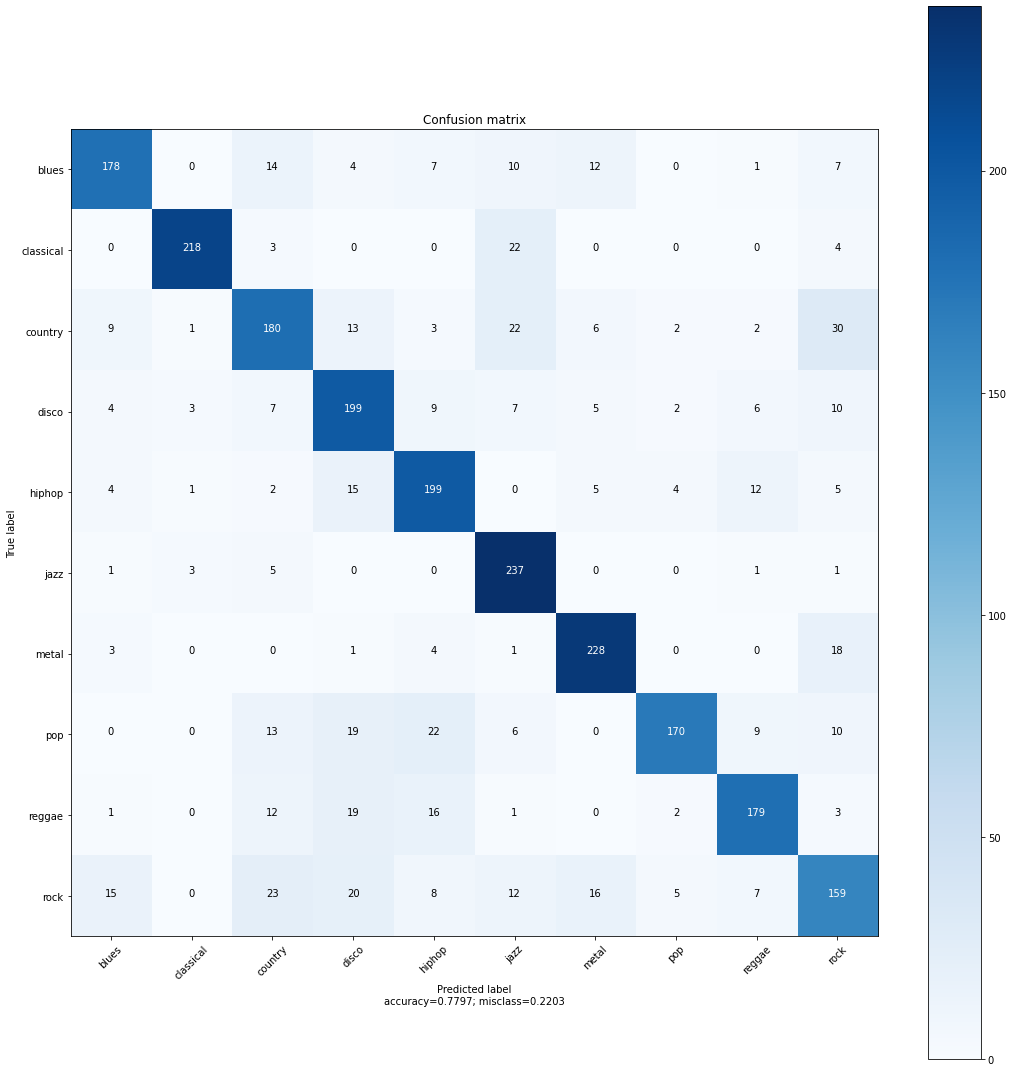

In [18]:
plot_confusion_matrix(cm=mat,
                      target_names=mapping,
                      title='Confusion matrix',
                      cmap=None,
                      normalize=False, 
                      size_mat=(15, 15))